In [ ]:
import pandas as pd
from typing import List, Tuple
import numpy as np

# Coil-Normalized CerberusTS Model

## Preprocess Functions

Our *downsample_timeseries_data* function takes wide-format timeseries data and dictionaries for the window sizes and relevant features for the *call*, *response*, and *context(s)* heads. 

In [ ]:
def downsample_timeseries_data(df: pd.DataFrame, 
                                feature_indexes: dict,
                                window_timesteps: dict
                                ) -> dict:
    processed_data = {}

    # Function to downsample the DataFrame
    def downsample(df, window):
        """
        Downsample the DataFrame, taking the mean of each window and setting the 
        index to the maximum timestamp in that window.
        """
        # First, calculate the mean for each window
        mean_df = df.resample(window).mean()

        # Then, find the maximum timestamp in each window
        max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())

        # Set the maximum timestamps as the new index
        mean_df.index = max_timestamps.values

        return mean_df

    for key in feature_indexes:
        processed_data[key] = downsample(df.iloc[:,feature_indexes[key]], window_timesteps[key])

    return processed_data


Our *slice_timeseries_data* function assembles the inputs for the *call*, *response*, and *context(s)* heads by searching over the timesteps for periods with sufficient preceding data for the *call* and *context* while also having a sufficiently sized following window for the *response* window. This function will also output the selected timestamps. 

In [ ]:
def slice_timeseries_data(data_to_slice: pd.DataFrame,
                          downsampled_data: pd.DataFrame, 
                            sizes: dict,
                            thresholds: dict) -> np.array:
    
    def get_max_timestamp_less_than(timestamp, df_sel):
    # Find the maximum timestamp less than the given timestamp
        filtered_timestamps = df_sel.index[df_sel.index < timestamp]
        return filtered_timestamps.max() if not filtered_timestamps.empty else None

    def get_preceding_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve a specified number of timestamps preceding (and excluding) the given timestamp.
        """
        # Find the maximum timestamp less than the given timestamp
        max_less_than_timestamp = get_max_timestamp_less_than(timestamp, df_sel)
        if max_less_than_timestamp is None:
            return pd.DataFrame()  # Return empty DataFrame if no suitable timestamp is found

        # Find the index of this timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')

        # Extract the preceding timestamps
        start_idx = max(closest_idx - slice_size, 0)
        relevant_timestamps = df_sel.iloc[start_idx:closest_idx, :]
        
        return relevant_timestamps  
    
    def get_following_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve timestamps equal to or greater than the selected timestamp.
        """
        # Find the index of the closest timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')
        
        # Ensure index is within bounds
        if closest_idx >= len(df_sel):
            return pd.DataFrame()  # Return empty DataFrame if index is out of bounds

        # Extract the following timestamps
        end_idx = min(closest_idx + slice_size, len(df_sel))
        relevant_timestamps = df_sel.iloc[closest_idx:end_idx, :]
        
        return relevant_timestamps
    
    def fill_numpy(relevant_timestamps,slice_size, direction):
        # Create a placeholder array
        placeholder_array = np.zeros([slice_size, relevant_timestamps.shape[1]])
        
        # Fill the placeholder array from the bottom
        if direction == "preceding":
            placeholder_array[-len(relevant_timestamps):] = relevant_timestamps.to_numpy()
        else:
            placeholder_array[:len(relevant_timestamps)] = relevant_timestamps.to_numpy()
        
        return placeholder_array
    
    sliced_data = {}
    for key in data_to_slice:
        sliced_data[key] = []
    # To store our last known unnormalized value
    sliced_data['last_known'] = []
    
    selected_timestamps = []
    # Loop through each timestamp in your data_to_slice
    for timestamp in data_to_slice['response'].index:
        
        # Check if we have enough, call, context, and response data. 
        check_size_dict={}
        for key in data_to_slice:
            if key == 'response':
                check_size_dict[key] = get_following_timestamps(timestamp, data_to_slice[key], sizes[key])
            else:
                check_size_dict[key] = get_preceding_timestamps(timestamp, data_to_slice[key], sizes[key])
            
        size_check = []
        for key, value in check_size_dict.items():
            size_check.append((value.shape[0] / sizes[key]) >= thresholds[key])

        if size_check.count(False)==0:
            # Add timestamp to list
            selected_timestamps.append(timestamp)
    
            for key in check_size_dict:
                if key == 'response':
                    direction = 'following'
                else:
                    direction = 'preceding'
                # Append the result of get_preceding_timestamps to the list in the dictionary
                sliced_data[key].append(fill_numpy(check_size_dict[key], sizes[key], direction))
            # Include last known value (pre-normalization) from call
            sliced_data['last_known'].append(get_preceding_timestamps(timestamp, downsampled_data['call'], 1))
            
    # After the loop, use np.vstack to combine the arrays for each key
    stacked_arrays_dict = {key: np.stack(value) for key, value in sliced_data.items()}
    
    return stacked_arrays_dict, selected_timestamps

Our *masked_expand* function performs the masking on *response* head to ensure that the objective values for a prediction are never in the *response* used to generate that prediction; instead the *response* head only contains values leading up to the output values for that prediction. 

In [ ]:

def masked_expand(sliced_data, sizes):
    sizes['response']
    
    expanded_dict = {}
    for key, value in sliced_data.items():
        if key == "response":
            res_shape = value.shape
            response_data = value.reshape(res_shape[0]*res_shape[1],res_shape[2])
            mask_array = np.tile(np.repeat(np.tril(np.ones([res_shape[1],res_shape[1]]),-1)[:,:,np.newaxis], res_shape[2], axis=2), (res_shape[0], 1, 1))
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0) * mask_array
        else:
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0)
            
    unmasked_response = np.repeat(sliced_data['response'],sizes['response'],axis=0)
            
    return expanded_dict, response_data, unmasked_response

We will create some functions for coil normalization, where we express the discrete derivative as a superposition of some maximum increase and maximum decrease. 

$$
\Delta_{t}f(t) = f(t+1) - f(t) = a\Delta_{max}-b\Delta_{max}
$$

where 

$$
a + b = 1
$$

It follows that 

$$
a = \frac{\Delta_{t}f(t)+\Delta_{max}}{2\Delta_{max}}
$$

Expressing the dynamics of the signal allows for us to model the behaviour of the system as a flow of probabilities between discrete system states. 

Our *coil_normalization* function will first compute the maximum absolute change of each feature, and then calculate the probability provided by the formula above. 

In [ ]:
def coil_normalization(df):
    def max_absolute_change(df_diff):
        # Calculate the absolute change for each feature
        abs_change = df_diff.abs()

        # Find the maximum absolute change for each feature
        max_changes = abs_change.max()

        # Convert the series to a DataFrame
        max_change_df = max_changes.to_frame(name='Max Absolute Change')

        return max_change_df
    
    # Calculate the change for each feature
    df_diff = df.diff()
    # Calculate the max absolute change for each feature
    max_change_df = max_absolute_change(df_diff)
    
    normalized_df = pd.DataFrame()

    for column in df_diff.columns:
        max_change_val = max_change_df.loc[column,'Max Absolute Change']
        normalized_df[column] = (df_diff[column] + max_change_val) / (2 * max_change_val)
    # Set first row to 0 as there is no diff
    normalized_df.iloc[0] = normalized_df.iloc[0].fillna(0)
       
    return normalized_df, max_change_df

In [ ]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')

In [ ]:
df = df.iloc[:5000,:]

In [ ]:
normalized_df, max_change_df = coil_normalization(df)
normalized_df

We also want to be able to reconstruct the original signal at any point given the last known value and the coil-normalized values. 

In [ ]:
def denormalize(normalized_df, max_change_df, initial_value, start_idx, end_idx):
    # Initialize the reconstructed DataFrame with the initial value
    reconstructed_df = pd.DataFrame(index=normalized_df.index[start_idx-1:end_idx])
    for column in normalized_df.columns:
        reconstructed_df[column] = initial_value[column]
        # Iteratively reconstruct the signal
        for i in range(start_idx, end_idx):
            delta_max = max_change_df.loc[column, 'Max Absolute Change']
            delta_t = 2 * normalized_df.at[normalized_df.index[i], column] * delta_max - delta_max
            reconstructed_df.at[normalized_df.index[i], column] = reconstructed_df.at[normalized_df.index[i - 1], column] + delta_t
    reconstructed_df.drop(index=reconstructed_df.index[0], axis=0, inplace=True)
    return reconstructed_df

# Example usage:
# Assuming `df` is the original DataFrame and we want to reconstruct the signal for a specific time window
start_idx = 100
end_idx = 200
initial_value = df.iloc[start_idx-1]  # Last known value before the time window
reconstructed_df = denormalize(normalized_df, max_change_df, initial_value, start_idx, end_idx)
print(reconstructed_df)


In [ ]:
# Compare the reconstructed data with the original data
original_slice = df.iloc[start_idx:end_idx]
print(original_slice)

In [ ]:
import matplotlib.pyplot as plt

# Assuming original_slice and reconstructed_df are already defined
# Plotting each feature
n_features = len(df.columns)
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

for i, column in enumerate(df.columns):
    axes[i].plot(original_slice.index, original_slice[column], label='Original', marker='o')
    axes[i].plot(reconstructed_df.index, reconstructed_df[column], label='Reconstructed', marker='x')
    axes[i].set_title(column)
    axes[i].legend()

plt.tight_layout()
plt.show()


We can train a model directly on the coil-normalized values, but this does not provide context on the magnitude the signals; just the dynamics. To provide context on the magnitudes we will also min-max scale the data and pass the last known scaled value as an additional CerberusTS input. 

In [ ]:
def create_min_max_df(df):
    """Create a DataFrame with min and max values for each feature."""
    min_values = df.min()
    max_values = df.max()
    min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
    return min_max_df

def scale_data(df, min_max_df, feature_range=(0, 1)):
    """Scale data in df based on min-max values and a given feature range."""
    min_scale, max_scale = feature_range
    scaled_df = pd.DataFrame()

    for column in df.columns:
        min_val = min_max_df.loc[column, 'min']
        max_val = min_max_df.loc[column, 'max']
        # Avoid division by zero in case of constant columns
        if max_val != min_val:
            scaled_df[column] = (df[column] - min_val) / (max_val - min_val) * (max_scale - min_scale) + min_scale
        else:
            scaled_df[column] = df[column]

    return scaled_df

## CerberusTS configuration

Now we will specify our required configurations for Cerberus

In [ ]:
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

window_sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)   
}

We will first min-max scale the data to be in a range of 0 to 1. 

In [ ]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

Next we will make a dictionary of downsampled dataframes based on the user specified windows and features. 

In [ ]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        feature_indexes,
                                        window_timesteps)
downsampled_data

For each entry in our downsampled_data dictionary we will perform coil normalization. 

In [ ]:
normalized_data = {}
max_change_dfs = {}
for key in downsampled_data:
    normalized_data[key], max_change_dfs[key] = coil_normalization(downsampled_data[key])

In [ ]:
print(normalized_data['call'].iloc[0:2,:])
print(normalized_data['response'].iloc[0:2,:])

Next we will slice the normalized data into the required inputs for the CerberusTS heads. The downsampled data is used to provide the last known value as an input to the model. 

In [ ]:
sliced_data, selected_timestamps = slice_timeseries_data(normalized_data,
                                                        downsampled_data,
                                                        sizes,
                                                        thresholds)

In [ ]:
for key in sliced_data:
    print(sliced_data[key].shape)

Let's confirm that our slicing looks good by checking the call and the response slices for a specific value

In [ ]:
check_indx = 100
print(sliced_data['call'][check_indx,:,:])
print(sliced_data['response'][check_indx,:,:])

Finally, we will perform our masked expansion on the data. 

In [ ]:
expanded_dict, response_data, unmasked_response = masked_expand(sliced_data, sizes)

In [ ]:
print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

# Cerberus Construction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def ksize(size):
    return max([2, round(size / 9)])

class FormHead(nn.Module):
    def __init__(self, size, feature_len, csize=64, channels=2):
        super(FormHead, self).__init__()
        self.conv = nn.Conv2d(channels, csize, kernel_size=(ksize(size), ksize(feature_len)))
        self.pool = nn.MaxPool2d(2, 2)
        # Placeholder for the linear layer
        self.fc = None

    def forward(self, x):
        x = F.leaky_relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        if self.fc is None:
            # Dynamically compute the input size for the linear layer
            size = x.size(1)
            self.fc = nn.Linear(size, 64)
        x = F.leaky_relu(self.fc(x))
        return x

class Cerberus(nn.Module):
    def __init__(self, training_data, response_data, csize=64):
        super(Cerberus, self).__init__()
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)

        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
        self.fc3 = nn.Linear(csize * 8 + train_call.shape[2], csize * 4)
        self.fc4 = nn.Linear(csize * 4, csize)
        self.fc5 = nn.Linear(csize, csize // 2)
        self.out = nn.Linear(csize // 2, response_data.shape[1])

    def forward(self, x_call, x_contexts, x_response, x_lastknown):
        call_head_out = self.call_head(x_call)
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        
        last_known = x_lastknown
        
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        body = F.leaky_relu(self.fc3(torch.cat([necks] + [last_known], dim=1)))
        body = F.leaky_relu(self.fc4(body))
        body = F.leaky_relu(self.fc5(body))
        body = self.out(body)
        return body

We can use a nice function to create the PyTorch tensors, where the first channel will be the data we have calculated and the second channel will simply be 1 minus that channel. 

In [ ]:
def make_torch_tensor(channel_array):
    first_channel = torch.tensor(channel_array, dtype=torch.float32)

    # Create the second channel as 1 minus the first channel
    second_channel = 1 - first_channel

    # Combine both channels to form a two-channel tensor
    # The unsqueeze(1) adds a channel dimension
    both_channels = torch.stack((first_channel, second_channel), dim=1)
    
    return both_channels

### CerberusTS training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import random

num_epochs = 30

model = Cerberus(expanded_dict, response_data)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_len = 20_000
train_index = random.sample(range(train_len),train_len)

# We will convert our numpy arrays to 2-channel tensors
calls = make_torch_tensor(expanded_dict['call'][train_index,:,:])
contexts = [make_torch_tensor(expanded_dict[key][train_index,:,:]) for key in expanded_dict if 'context' in key]
responses = make_torch_tensor(expanded_dict['response'][train_index,:,:])

# Last knowns isn't coil-normalized so we won't process it as such
last_knowns = torch.tensor(expanded_dict['last_known'][train_index,0,:], dtype=torch.float32)

# We don't need to produce both channels of the coil normalization, we can just do the first. 
y = torch.tensor(response_data[train_index,:], dtype=torch.float32)
batch_size = 100
batch_range = range(0, len(calls), batch_size)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in batch_range:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(calls[i:i+batch_size], [cont[i:i+batch_size] for cont in contexts], responses[i:i+batch_size],last_knowns[i:i+batch_size])
        loss = criterion(outputs, y[i:i+batch_size])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(batch_range)}")

In [ ]:
# 3. Set the model to evaluation mode
model.eval()

# 4. Run the model forward pass
with torch.no_grad():  # No need to compute gradients during inference
    predictions = model(calls, contexts, responses, last_knowns)
predictions = predictions.numpy()

print(predictions)

Once the model is trained, we will generate the predictions autoregressively by first loading in a response head of all 0s, with a known call and contexts. We generate a prediction, then pass this result into the respone head. This is repeated until all predictions are generated for the required window. 

In [ ]:
def generate_predictions(model,selected_data):
    calls = make_torch_tensor(selected_data['call'])
    contexts = [make_torch_tensor(selected_data[key]) for key in expanded_dict if 'context' in key]
    responses = make_torch_tensor(np.zeros([1,selected_data['response'].shape[1],selected_data['response'].shape[2]]))

    # Last knowns isn't coil-normalized so we won't process it as such
    last_knowns = torch.tensor(selected_data['last_known'][:,0,:], dtype=torch.float32)

    respones_generated = []
    for igen in range(responses.shape[2]):
        with torch.no_grad():
            res_out = model(calls, contexts, responses, last_knowns)
            responses[0,0,igen,:] = res_out[0]
            respones_generated.append(res_out[0].numpy())
        
    return np.vstack(respones_generated)

In [172]:
sel_indx = 4000

selected_data = {key: value[sel_indx:sel_indx+1,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

[[[0.56790123 0.48717949 0.50501002]
  [0.5        0.51602564 0.51002004]
  [0.46296296 0.4775641  0.48997996]
  [0.5617284  0.49679487 0.51002004]
  [0.61728395 0.50961538 0.48997996]
  [0.5617284  0.48076923 0.48997996]
  [0.48765432 0.49358974 0.51002004]
  [0.54938272 0.48717949 0.48997996]]]
[[0.4104146  0.5345754  0.49050406]
 [0.4175687  0.45161006 0.5200887 ]
 [0.40973976 0.4793575  0.5265542 ]
 [0.39604154 0.459276   0.5574267 ]
 [0.395362   0.47138467 0.5480507 ]
 [0.388804   0.49291173 0.52765894]
 [0.38391814 0.5541209  0.50084054]
 [0.39062998 0.5467445  0.49672276]]


We can evaluate how our model generates response by looking at the changes:

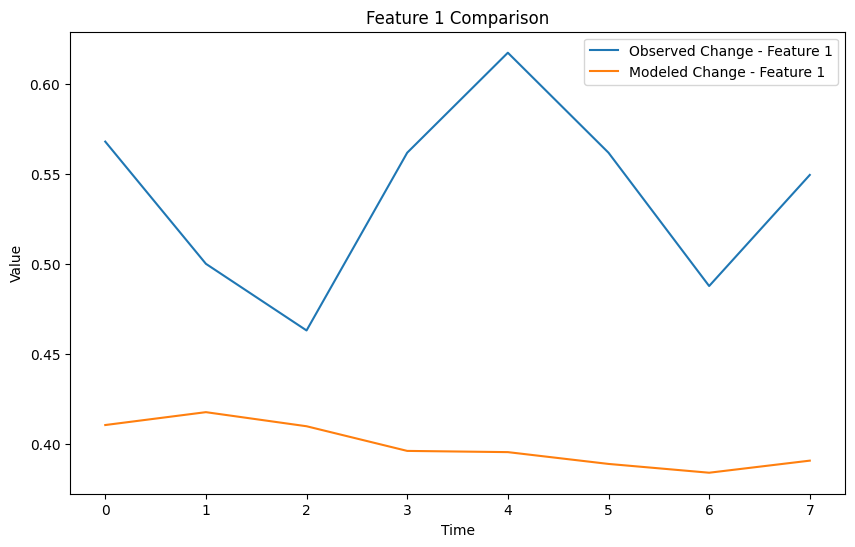

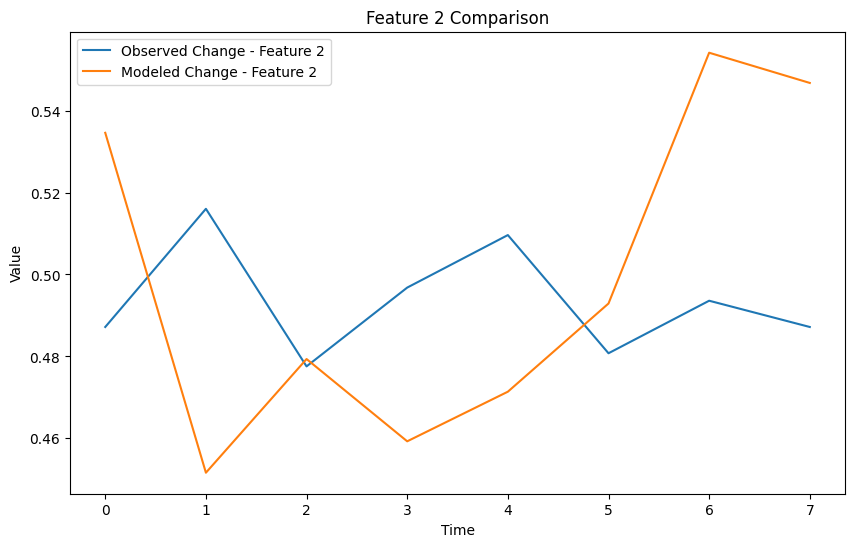

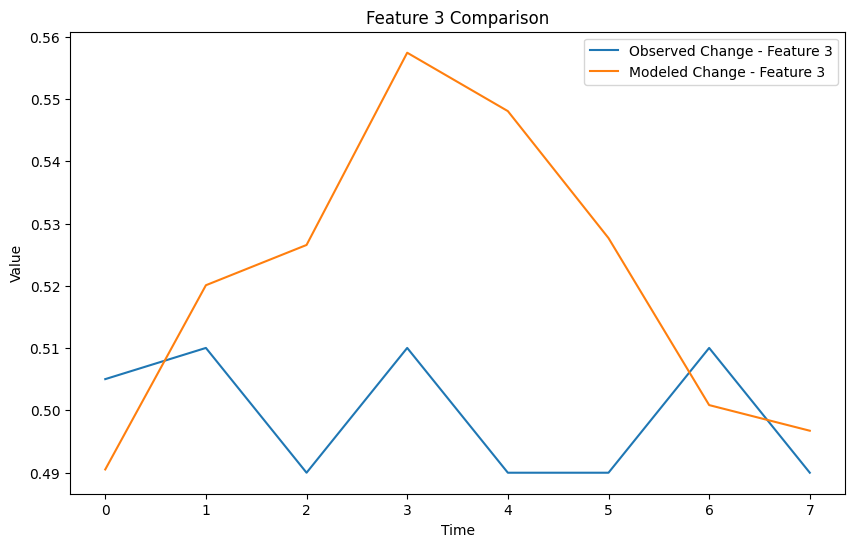

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed Change - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled Change - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

But for a more fair comparison, we should look at the denormalized values. This is a little tricky to track back down where they are but this looks right

In [174]:
#First we have to pull the relevant downsampled data:
start_timestamp = selected_timestamps[sel_indx]
freq = window_timesteps['response']  # Example frequency
print(start_timestamp)
start_timestamp = start_timestamp - pd.to_timedelta( 1* pd.Timedelta(freq)) #why do we have to count back in time?
end_timestamp = start_timestamp + pd.to_timedelta((window_sizes['response']+1) * pd.Timedelta(freq))

# Access data at these future timestamps
observed_slice = downsampled_data['response'].loc[start_timestamp:end_timestamp]

observed_change = selected_data['response'][0,:,:]

normalized_df = observed_slice.copy()
normalized_df.iloc[1:window_sizes['response']+1,:]=observed_change
observed_df = denormalize(normalized_df,max_change_dfs['response'],initial_value=observed_slice.iloc[0,:],start_idx= 1,end_idx= window_sizes['response']+1)
print(observed_df)
print(observed_slice)

2009-01-30 06:40:00
                     p (mbar)  T (degC)    rh (%)
2009-01-30 06:40:00  0.889416  0.667210  0.671989
2009-01-30 06:50:00  0.889416  0.668842  0.675460
2009-01-30 07:00:00  0.888434  0.666558  0.671989
2009-01-30 07:10:00  0.890070  0.666232  0.675460
2009-01-30 07:20:00  0.893178  0.667210  0.671989
2009-01-30 07:30:00  0.894814  0.665253  0.668518
2009-01-30 07:40:00  0.894487  0.664600  0.671989
2009-01-30 07:50:00  0.895796  0.663295  0.668518
                     p (mbar)  T (degC)    rh (%)
2009-01-30 06:30:00  0.887617  0.668515  0.670253
2009-01-30 06:40:00  0.889416  0.667210  0.671989
2009-01-30 06:50:00  0.889416  0.668842  0.675460
2009-01-30 07:00:00  0.888434  0.666558  0.671989
2009-01-30 07:10:00  0.890070  0.666232  0.675460
2009-01-30 07:20:00  0.893178  0.667210  0.671989
2009-01-30 07:30:00  0.894814  0.665253  0.668518
2009-01-30 07:40:00  0.894487  0.664600  0.671989
2009-01-30 07:50:00  0.895796  0.663295  0.668518
2009-01-30 08:00:00  0.897595 

In [175]:
print(normalized_data['response'].loc[start_timestamp:end_timestamp])
print(observed_change)

                     p (mbar)  T (degC)   rh (%)
2009-01-30 06:30:00  0.493827  0.493590  0.48998
2009-01-30 06:40:00  0.567901  0.487179  0.50501
2009-01-30 06:50:00  0.500000  0.516026  0.51002
2009-01-30 07:00:00  0.462963  0.477564  0.48998
2009-01-30 07:10:00  0.561728  0.496795  0.51002
2009-01-30 07:20:00  0.617284  0.509615  0.48998
2009-01-30 07:30:00  0.561728  0.480769  0.48998
2009-01-30 07:40:00  0.487654  0.493590  0.51002
2009-01-30 07:50:00  0.549383  0.487179  0.48998
2009-01-30 08:00:00  0.567901  0.487179  0.51002
[[0.56790123 0.48717949 0.50501002]
 [0.5        0.51602564 0.51002004]
 [0.46296296 0.4775641  0.48997996]
 [0.5617284  0.49679487 0.51002004]
 [0.61728395 0.50961538 0.48997996]
 [0.5617284  0.48076923 0.48997996]
 [0.48765432 0.49358974 0.51002004]
 [0.54938272 0.48717949 0.48997996]]


In [176]:
modeled_change = responses_generated

normalized_df = observed_slice.copy()
normalized_df.iloc[1:window_sizes['response']+1,:]=modeled_change
modeled_df = denormalize(normalized_df,max_change_dfs['response'],initial_value=observed_slice.iloc[0,:],start_idx= 1,end_idx= window_sizes['response']+1)
print(observed_slice)
print(modeled_df)

                     p (mbar)  T (degC)    rh (%)
2009-01-30 06:30:00  0.887617  0.668515  0.670253
2009-01-30 06:40:00  0.889416  0.667210  0.671989
2009-01-30 06:50:00  0.889416  0.668842  0.675460
2009-01-30 07:00:00  0.888434  0.666558  0.671989
2009-01-30 07:10:00  0.890070  0.666232  0.675460
2009-01-30 07:20:00  0.893178  0.667210  0.671989
2009-01-30 07:30:00  0.894814  0.665253  0.668518
2009-01-30 07:40:00  0.894487  0.664600  0.671989
2009-01-30 07:50:00  0.895796  0.663295  0.668518
2009-01-30 08:00:00  0.897595  0.661990  0.671989
                     p (mbar)  T (degC)    rh (%)
2009-01-30 06:40:00  0.885242  0.672035  0.666964
2009-01-30 06:50:00  0.883058  0.667109  0.673923
2009-01-30 07:00:00  0.880666  0.665008  0.683121
2009-01-30 07:10:00  0.877911  0.660862  0.703014
2009-01-30 07:20:00  0.875138  0.657950  0.719660
2009-01-30 07:30:00  0.872191  0.657228  0.729241
2009-01-30 07:40:00  0.869115  0.662737  0.729532
2009-01-30 07:50:00  0.866217  0.667496  0.728397


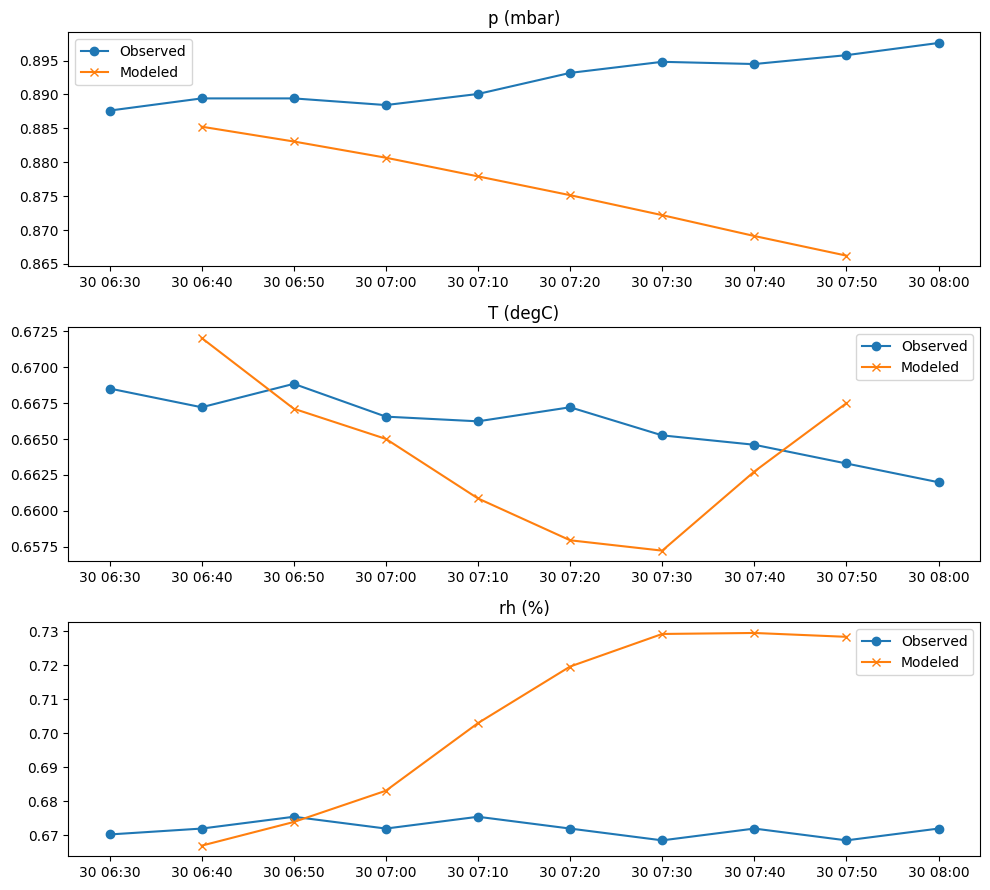

In [177]:
import matplotlib.pyplot as plt

n_features = len(observed_slice.columns)
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

for i, column in enumerate(observed_slice.columns):
    axes[i].plot(observed_slice.index, observed_slice[column], label='Observed', marker='o')
    axes[i].plot(modeled_df.index, modeled_df[column], label='Modeled', marker='x')
    axes[i].set_title(column)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [179]:
print(observed_slice.iloc[1:9,:].shape)
print(modeled_df.shape)

from sklearn.metrics import mean_squared_error
mean_squared_error(observed_slice.iloc[1:9,:],modeled_df)

(8, 3)
(8, 3)


0.0006924172799764597